In [35]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, localize_inloc, visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pipeline for indoor localization

## Setup
Here we declare the paths to the dataset, image pairs, and we choose the feature extractor and the matcher. You need to download the [InLoc dataset](https://www.visuallocalization.net/datasets/) and put it in `datasets/inloc/`, or change the path.

In [2]:
dataset = Path("datasets/lamar-hg/")  # change this if your dataset is somewhere else

pairs = Path("pairs/lamar-hg/")
loc_pairs = pairs / "generated-pairs.txt"  # top 40 retrieved by NetVLAD

outputs = Path("outputs/lamar-hg/")  # where everything will be saved
results = outputs / "InLoc_hloc_superpoint+superglue_netvlad40.txt"  # the result file

In [3]:
# list the standard configurations available
print(f"Configs for feature extractors:\n{pformat(extract_features.confs)}")
print(f"Configs for feature matchers:\n{pformat(match_features.confs)}")

Configs for feature extractors:
{'d2net-ss': {'model': {'multiscale': False, 'name': 'd2net'},
              'output': 'feats-d2net-ss',
              'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'dir': {'model': {'name': 'dir'},
         'output': 'global-feats-dir',
         'preprocessing': {'resize_max': 1024}},
 'disk': {'model': {'max_keypoints': 5000, 'name': 'disk'},
          'output': 'feats-disk',
          'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'eigenplaces': {'model': {'name': 'eigenplaces'},
                 'output': 'global-feats-eigenplaces',
                 'preprocessing': {'resize_max': 1024}},
 'netvlad': {'model': {'name': 'netvlad'},
             'output': 'global-feats-netvlad',
             'preprocessing': {'resize_max': 1024}},
 'openibl': {'model': {'name': 'openibl'},
             'output': 'global-feats-openibl',
             'preprocessing': {'resize_max': 1024}},
 'r2d2': {'model': {'max_keypoints': 5000, 'name': 'r

In [4]:
# pick one of the configurations for extraction and matching
# you can also simply write your own here!
feature_conf = extract_features.confs["superpoint_inloc"]
matcher_conf = match_features.confs["superglue"]

In [5]:
image_list = [
    'hl_2020-12-13-10-20-30-996/processed_data/images/',
    'hl_2020-12-13-10-28-16-176/processed_data/images/',
    'hl_2020-12-13-10-31-56-121/processed_data/images/',
    'hl_2020-12-13-10-38-12-139/processed_data/images/',
    'hl_2020-12-13-10-45-04-168/processed_data/images/',
    'hl_2020-12-13-10-48-10-582/processed_data/images/',
    'hl_2020-12-13-10-51-35-642/processed_data/images/',
    'hl_2020-12-13-11-02-13-691/processed_data/images/',
    'hl_2020-12-13-11-22-30-693/processed_data/images/',
    'hl_2020-12-13-11-28-20-676/processed_data/images/',
    'ios-random'
]

In [7]:
from hloc import pairs_from_retrieval

retrieval_conf = extract_features.confs["netvlad"]
reference_sfm = outputs / "sfm_superpoint+superglue"  # the SfM model we will build

global_descriptors = extract_features.main(retrieval_conf, dataset, outputs, image_list=image_list)

pairs_from_retrieval.main(
    global_descriptors,
    loc_pairs,
    5,
    query_prefix="ios",
    db_prefix="hl_2020"
)

[2024/11/13 19:23:42 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/11/13 19:23:43 hloc INFO] Found 9023 images in root datasets/lamar-hg.
[2024/11/13 19:23:45 hloc INFO] Skipping the extraction.
[2024/11/13 19:23:45 hloc INFO] Extracting image pairs from a retrieval database.
[2024/11/13 19:23:52 hloc INFO] Found 200 pairs.


## Extract local features for database and query images

In [8]:
feature_path = extract_features.main(feature_conf, dataset, outputs, image_list=image_list)

[2024/11/13 19:23:56 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
[2024/11/13 19:23:56 hloc INFO] Found 9023 images in root datasets/lamar-hg.
[2024/11/13 19:24:01 hloc INFO] Skipping the extraction.


## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [9]:
match_path = match_features.main(
    matcher_conf, loc_pairs, feature_conf["output"], outputs
)

[2024/11/13 19:24:04 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2024/11/13 19:24:04 hloc INFO] Skipping the matching.


## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. Different from when localizing with Aachen, here we do not need a 3D SfM model here: the dataset already has 3D lidar scans. The file `InLoc_hloc_superpoint+superglue_netvlad40.txt` will contain the estimated query poses.

In [38]:
localize_inloc.main(
    dataset, loc_pairs, feature_path, match_path, results, skip_matches=5
)  # skip database images with too few matches

[2024/11/13 22:27:46 hloc INFO] Starting localization...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.45it/s]
[2024/11/13 22:27:54 hloc INFO] Writing poses to outputs/lamar-hg/InLoc_hloc_superpoint+superglue_netvlad40.txt...
[2024/11/13 22:27:54 hloc INFO] Writing logs to outputs/lamar-hg/InLoc_hloc_superpoint+superglue_netvlad40.txt_logs.pkl...
[2024/11/13 22:27:54 hloc INFO] Done!


Couldn't localize ios-random/165636320144.jpg
Couldn't localize ios-random/165427576783.jpg
Couldn't localize ios-random/165670849631.jpg
Couldn't localize ios-random/165638703210.jpg
Couldn't localize ios-random/165664200368.jpg
Couldn't localize ios-random/165715678030.jpg


## Visualization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

/media/ross/Daten/programming_data/mixed_reality/Hierarchical-Localization/hloc/utils/viz.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


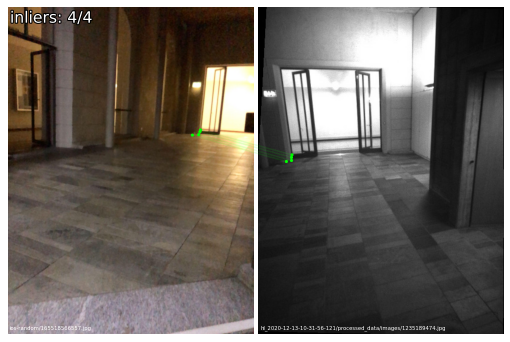

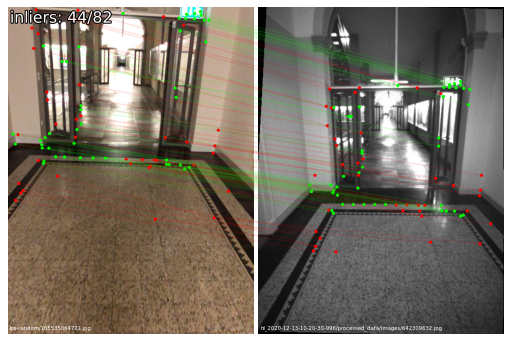

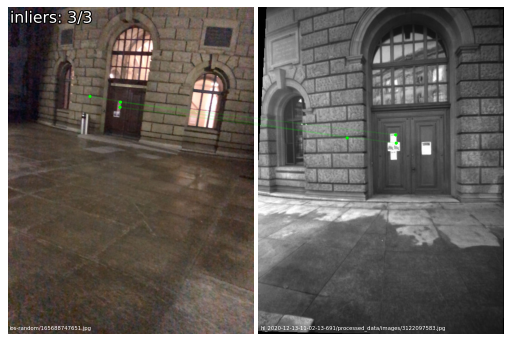

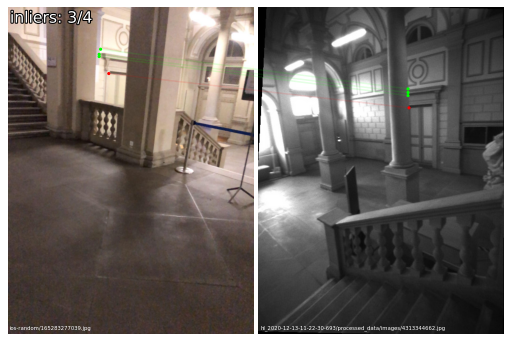

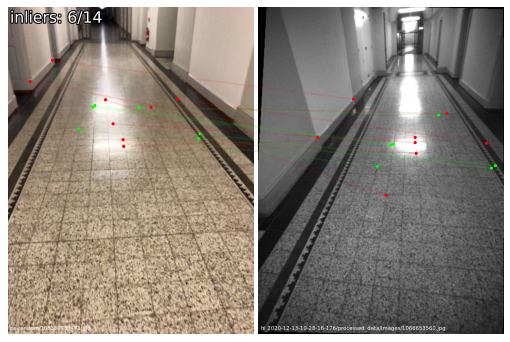

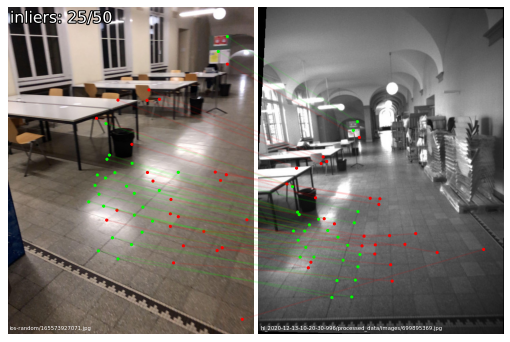

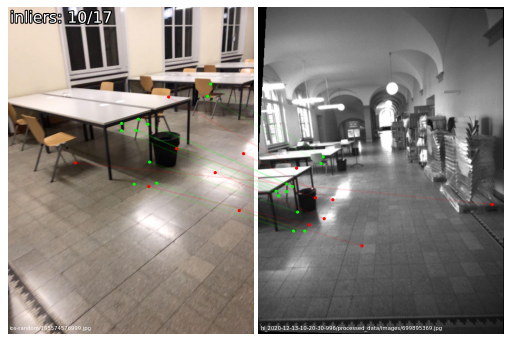

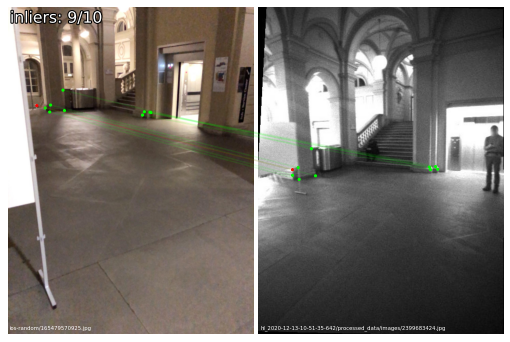

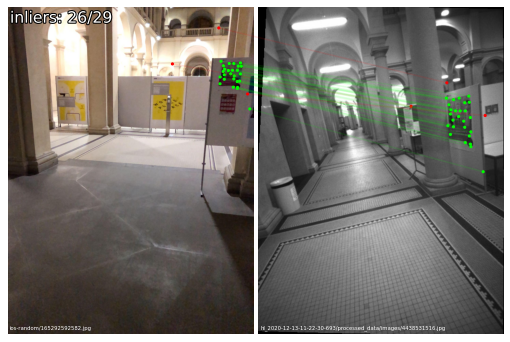

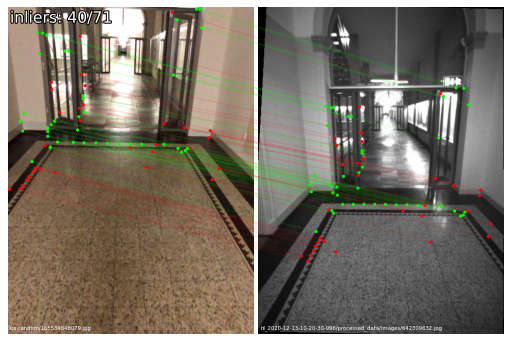

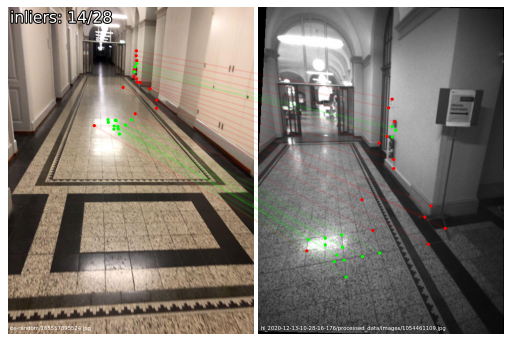

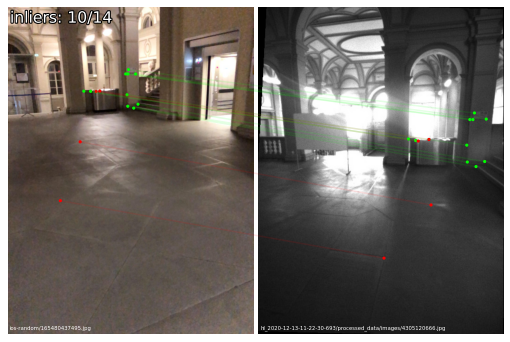

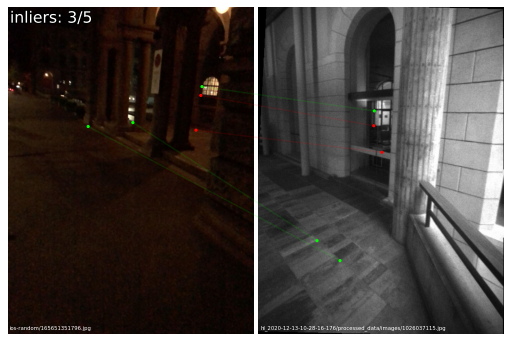

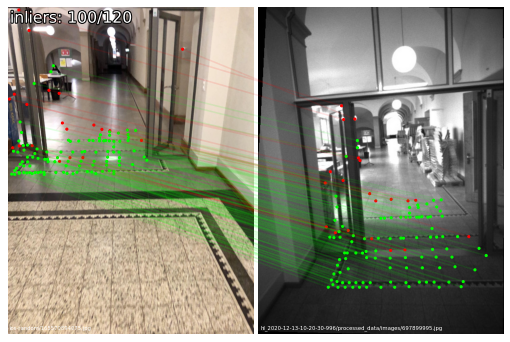

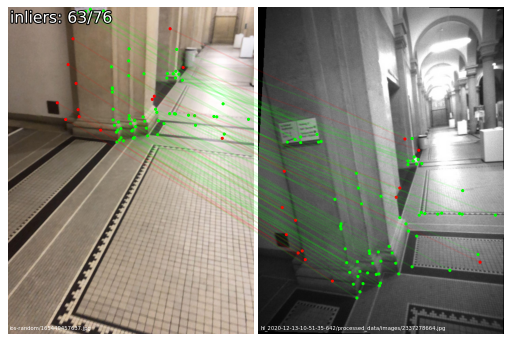

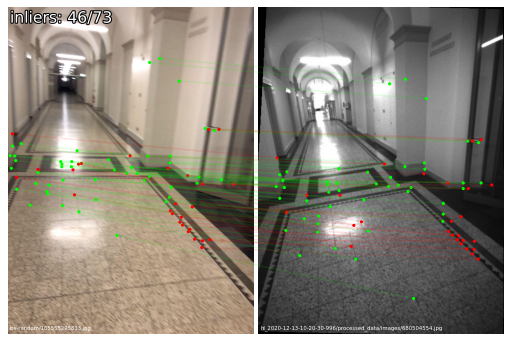

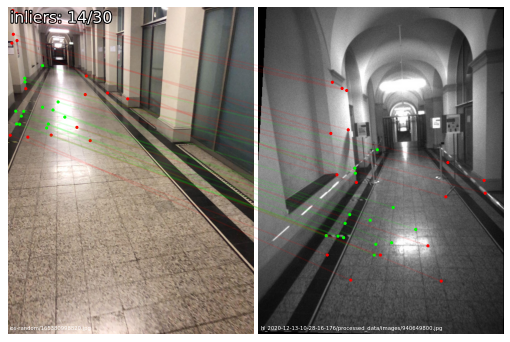

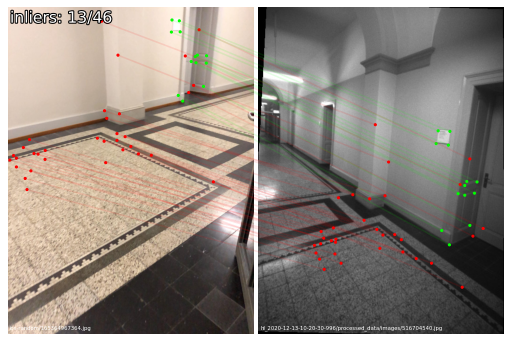

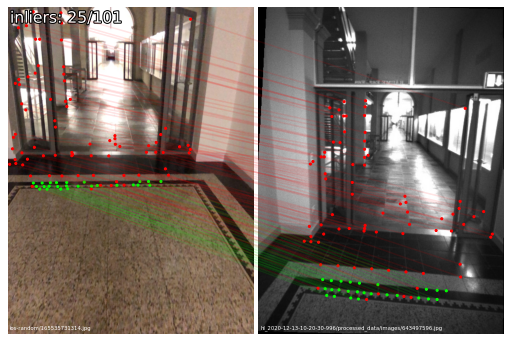

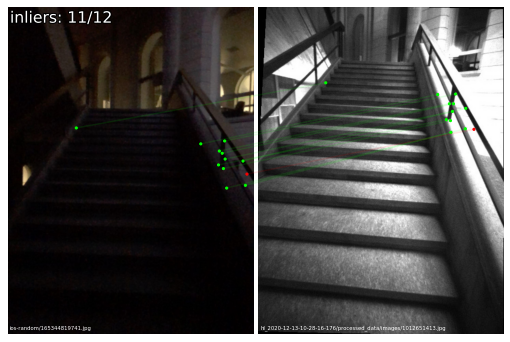

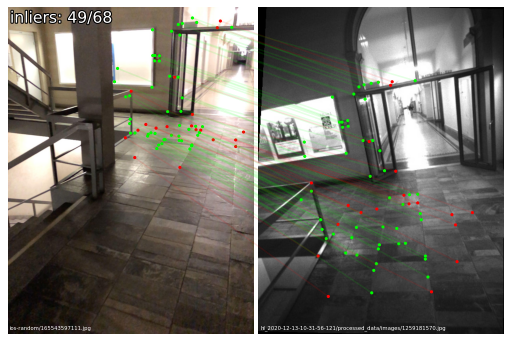

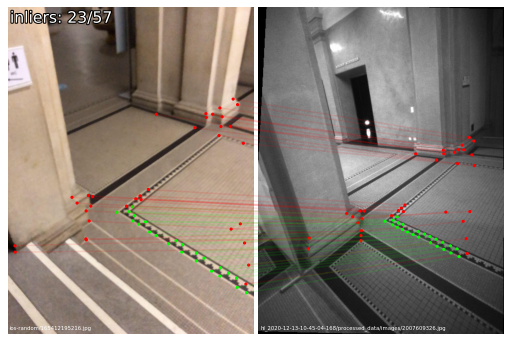

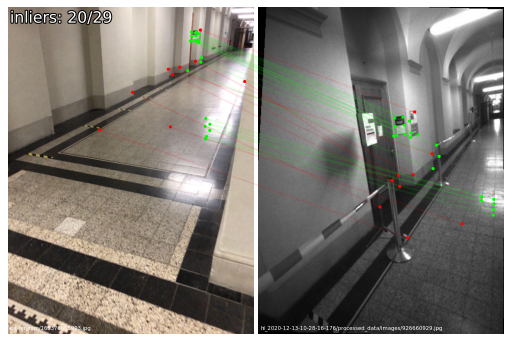

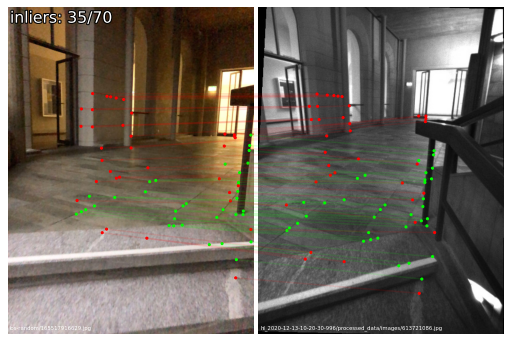

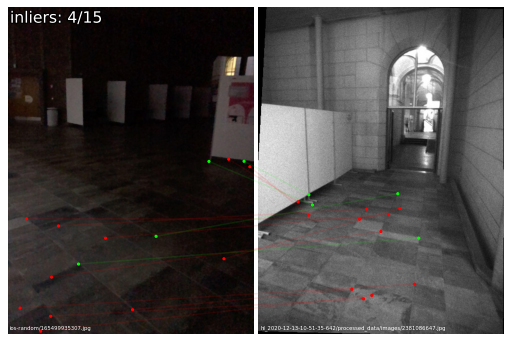

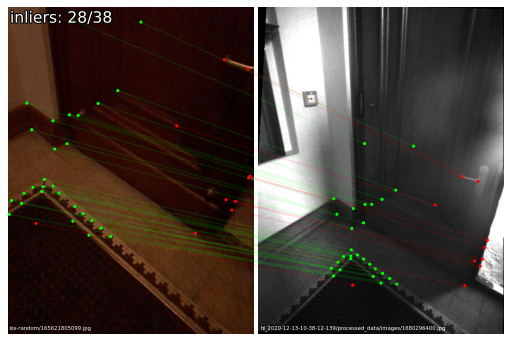

In [37]:
visualization.visualize_loc(results, dataset, n=40, top_k_db=1, seed=2)